In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score, accuracy_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


In [3]:
combined_stats = pd.read_csv('Data/FantasyFootballHealthProjections.csv')

### AvgSeasonGames- where applicable a 3 year average for veteran players, a two year average for recently drafted players, and for rookies how many games they played in the 2024 season.

### Criteria of the Dataset 
* HealthGrade = Basic Health Score (Based on Availability Only) for veterans, Case by Case basis for backups, and assuming 2025 Rookies will be healthy. 
* HealthStatus = 0 - Healthy (16-17 games), 1 - HealthyBackup, 2 - Minor Injuries (14-15 games), 3 - Moderate Injuries (10-13 games), 4 - Major Injuries (5-9 games), 5 - Significant Injuries (0-4 games).

In [7]:
combined_stats.head()

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthStatus,2023HealthStatus2,2024Age,2024G,2024HealthStatus,2024HealthStatus2,AvgSeasonGames,HealthGrade,2025Age,2025G
0,6,Lamar Jackson,BAL,QB,26,16.0,0,Healthy,27,17.0,0,Healthy,15.0,88,28,17
1,21,Ja'Marr Chase,CIN,WR/TE,23,16.0,0,Healthy,24,17.0,0,Healthy,15.0,88,25,17
2,1,Josh Allen,BUF,QB,27,17.0,0,Healthy,28,17.0,0,Healthy,17.0,100,29,16
3,11,Joe Burrow,CIN,QB,27,10.0,3,Moderate Injuries,28,17.0,0,Healthy,14.0,82,29,17
4,26,Baker Mayfield,TAM,QB,28,17.0,0,Healthy,29,17.0,0,Healthy,15.0,88,30,17


In [9]:
combined_stats.head().sort_values(by='HealthGrade', ascending=False)

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthStatus,2023HealthStatus2,2024Age,2024G,2024HealthStatus,2024HealthStatus2,AvgSeasonGames,HealthGrade,2025Age,2025G
2,1,Josh Allen,BUF,QB,27,17.0,0,Healthy,28,17.0,0,Healthy,17.0,100,29,16
0,6,Lamar Jackson,BAL,QB,26,16.0,0,Healthy,27,17.0,0,Healthy,15.0,88,28,17
1,21,Ja'Marr Chase,CIN,WR/TE,23,16.0,0,Healthy,24,17.0,0,Healthy,15.0,88,25,17
4,26,Baker Mayfield,TAM,QB,28,17.0,0,Healthy,29,17.0,0,Healthy,15.0,88,30,17
3,11,Joe Burrow,CIN,QB,27,10.0,3,Moderate Injuries,28,17.0,0,Healthy,14.0,82,29,17


In [11]:
combined_stats.sort_values(by='HealthGrade', ascending=False).tail()

,ID,Player,Tm,FantPos,2023Age,2023G,2023HealthStatus,2023HealthStatus2,2024Age,2024G,2024HealthStatus,2024HealthStatus2,AvgSeasonGames,HealthGrade,2025Age,2025G
246,185,Luke Musgrave,NaN,WR/TE,23,11.0,3,Moderate Injuries,24,7.0,4,Major Injuries,9.0,53,25,17
94,22,Anthony Richardson,NaN,QB,21,4.0,5,Significant Injuries,22,11.0,3,Moderate Injuries,8.0,47,23,17
278,230,Rondale Moore,NaN,WR/TE,23,17.0,0,Healthy,24,0.0,5,Significant Injuries,8.0,47,25,17
191,99,Deshaun Watson,NaN,QB,28,6.0,4,Major Injuries,29,7.0,4,Major Injuries,6.0,35,30,10
279,228,Elijah Mitchell,NaN,RB,25,11.0,3,Moderate Injuries,26,0.0,5,Significant Injuries,5.0,29,27,17


In [13]:
combined_stats.groupby('FantPos')['HealthGrade'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,38.0,88.657895,14.860207,35.0,82.0,94.0,100.0,100.0
RB,88.0,87.863636,12.866406,29.0,80.5,90.0,100.0,100.0
WR/TE,155.0,89.296774,11.334452,47.0,82.0,94.0,100.0,100.0


In [15]:
combined_stats.groupby('FantPos')['AvgSeasonGames'].describe()

,count,mean,std,min,25%,50%,75%,max
FantPos,,,,,,,,
QB,35.0,12.985714,3.830001,2.0,11.25,14.0,16.0,17.0
RB,76.0,14.282895,2.319965,5.0,13.00,15.0,16.0,17.0
WR/TE,145.0,14.841379,1.975284,8.0,14.00,15.0,16.0,17.0


In [17]:
combined_stats.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281 entries, 0 to 280
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ID                 281 non-null    int64  
 1   Player             281 non-null    object 
 2   Tm                 92 non-null     object 
 3   FantPos            281 non-null    object 
 4   2023Age            281 non-null    int64  
 5   2023G              220 non-null    float64
 6   2023HealthStatus   281 non-null    int64  
 7   2023HealthStatus2  281 non-null    object 
 8   2024Age            281 non-null    int64  
 9   2024G              257 non-null    float64
 10  2024HealthStatus   281 non-null    int64  
 11  2024HealthStatus2  281 non-null    object 
 12  AvgSeasonGames     256 non-null    float64
 13  HealthGrade        281 non-null    int64  
 14  2025Age            281 non-null    int64  
 15  2025G              281 non-null    int64  
dtypes: float64(3), int64(8), o

## Evaluate data using Train, Test, and Split with Random Forest Regression- HealthGrade

In [26]:
# Step 1: Function to train and predict for a specific position
# This function handles data filtering, model training, prediction, evaluation, and result formatting for a given NFL player position.
def train_and_predict(position, features):
    # Filters the dataset for a specific position, such as 'RB', 'WR/TE', or 'QB'.
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    # Uses .copy() to avoid modifying the original DataFrame.    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X (Predictor Variables) and y (Target Variable)
    X = position_data[features].fillna(0)
    y = position_data['HealthGrade'].fillna(0)

    # Reset index to preserve alignment
    X = X.reset_index(drop=True)
    y = y.reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Split and get indices
    # Ensures that the training and test data are split before training.
    X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
        X, y, position_data.index, test_size=0.2, random_state=42
    )

    # Train the model
    rf = RandomForestRegressor(
        n_estimators=100, 
        max_depth=10, 
        random_state=42
    )
    rf.fit(X_train, y_train)

    # Evaluate the model
    # y_pred_train: Predictions the model makes on the training set (the data it saw during learning).
    # y_pred_test: Predictions on the test set (data it did not see during training).
    y_pred_train = rf.predict(X_train)
    y_pred_test = rf.predict(X_test)

    print(f"\n{position} - Training MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
    print(f"{position} - Testing MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")

    # Feature importances
    feature_importances = rf.feature_importances_
    importance_df = pd.DataFrame({'Feature': features, 'Importance': feature_importances})
    importance_df = importance_df.sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions only for the correct subset
    # The resulting predictions are tagged as either 'Train' or 'Test'
    # train_df: Contains predictions for the training data — the model saw this during training.
    train_df = position_data.loc[idx_train, ['Player', 'FantPos', 'HealthGrade']].copy()
    train_df.loc[:, 'Data Split'] = 'Train'
    train_df.loc[:, 'PredictedHealthGrade'] = y_pred_train
    # test_df: Contains predictions for the testing data — the model never saw this during training.
    test_df = position_data.loc[idx_test, ['Player', 'FantPos', 'HealthGrade']].copy()
    test_df.loc[:, 'Data Split'] = 'Test'
    test_df.loc[:, 'PredictedHealthGrade'] = y_pred_test
    # Take the model’s predictions for the training and test data, combine them into one table, and reset the index so it's clean 
    # and ready for further analysis with the feature sets.
    return pd.concat([train_df, test_df], ignore_index=True)

# Step 2: Feature sets
rb_features = ['2023Age', '2023G', '2023HealthStatus', '2024Age', '2024G', '2024HealthStatus', 'AvgSeasonGames', '2025Age']
wrte_features = rb_features
qb_features = rb_features

# Step 3: Apply to all positions
rb_predictions = train_and_predict('RB', rb_features)
wrte_predictions = train_and_predict('WR/TE', wrte_features)
qb_predictions = train_and_predict('QB', qb_features)

# Step 4: Combine all predictions (only test/train predictions, no leakage)
# No information from the test set leaks into the training process or vice versa when combining these predictions.
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(0)

# Step 5: Save to CSV
output_path = "Data/FootballProjectedHealthGrades.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'PredictedHealthGrade', 'HealthGrade']].to_csv(output_path, index=False)


RB - Training MAE: 1.44
RB - Testing MAE: 1.56

RB - Feature Importances:
            Feature  Importance
5  2024HealthStatus    0.437970
6    AvgSeasonGames    0.320501
2  2023HealthStatus    0.120821
4             2024G    0.053042
1             2023G    0.032106
3           2024Age    0.013682
7           2025Age    0.011324
0           2023Age    0.010555

WR/TE - Training MAE: 0.79
WR/TE - Testing MAE: 2.13

WR/TE - Feature Importances:
            Feature  Importance
5  2024HealthStatus    0.376841
6    AvgSeasonGames    0.353880
2  2023HealthStatus    0.110278
4             2024G    0.080054
1             2023G    0.038416
0           2023Age    0.018741
3           2024Age    0.011679
7           2025Age    0.010111

QB - Training MAE: 2.61
QB - Testing MAE: 3.99

QB - Feature Importances:
            Feature  Importance
2  2023HealthStatus    0.524848
5  2024HealthStatus    0.139809
6    AvgSeasonGames    0.135983
0           2023Age    0.048525
7           2025Age    0.04099

In [158]:
# Evaluate R² and MAE by position
# Start with an empty Python list
position_metrics = []
# test_only = all_predictions[all_predictions['Data Split'] == 'Test']
# train_only = all_predictions[all_predictions['Data Split'] == 'Train']

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['HealthGrade'], subset['PredictedHealthGrade'])
    mae = mean_absolute_error(subset['HealthGrade'], subset['PredictedHealthGrade'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})
    
# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nHealth Metrics by Position:")
print(position_metrics_df)


Health Metrics by Position:
  Position     R²   MAE
0       RB  0.951  1.43
1    WR/TE  0.939  1.02
2       QB  0.909  2.87


In [160]:
# Evaluate R² and MAE by position (testing data only)
# Start with an empty Python list
position_metrics = []

# Filter for test data only
test_only = all_predictions[all_predictions['Data Split'] == 'Test']

for pos in test_only['FantPos'].unique():
    subset = test_only[test_only['FantPos'] == pos]
    r2 = r2_score(subset['HealthGrade'], subset['PredictedHealthGrade'])
    mae = mean_absolute_error(subset['HealthGrade'], subset['PredictedHealthGrade'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# So after the loop, position_metrics becomes a list of dictionaries, which is then converted to a pandas dataframe
# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nHealth Metrics by Position (Test Data Only):")
print(position_metrics_df)


Health Metrics by Position (Test Data Only):
  Position     R²   MAE
0       RB  0.926  1.44
1    WR/TE  0.892  2.06
2       QB -0.517  3.88


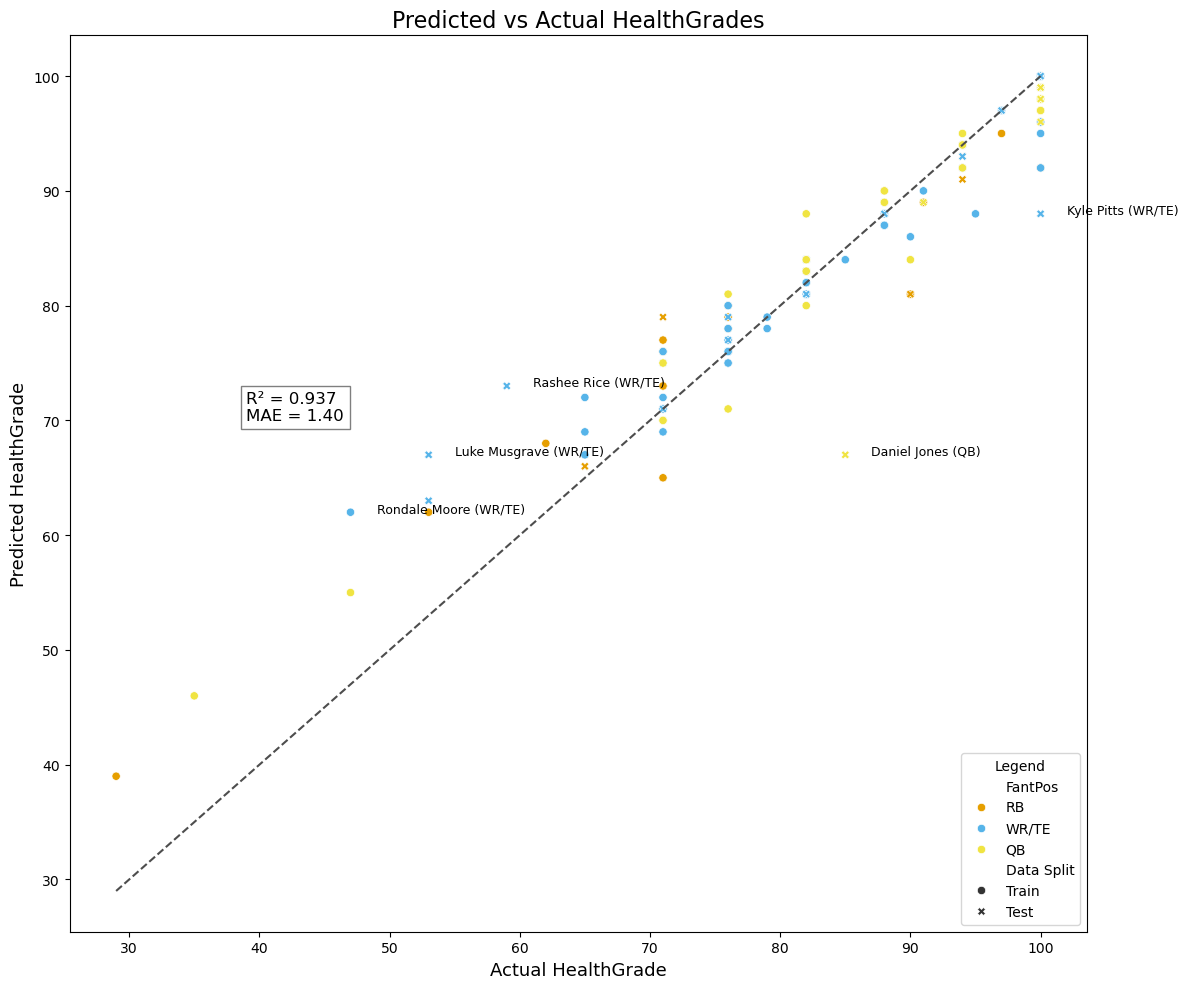

In [152]:
# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['HealthGrade'], all_predictions['PredictedHealthGrade'])
mae = mean_absolute_error(all_predictions['HealthGrade'], all_predictions['PredictedHealthGrade'])

# Compute residuals to find largest errors
all_predictions['Residual'] = np.abs(all_predictions['HealthGrade'] - all_predictions['PredictedHealthGrade'])
top_outliers = all_predictions.nlargest(5, 'Residual')  # Top 5 biggest errors

# Color palette for accessibility (Color Universal Design and Colorblind safe)

color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'QB': '#F0E442'   # yellow
}
# Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=all_predictions,
    x='HealthGrade', y='PredictedHealthGrade',
    hue='FantPos', style='Data Split',
    palette=color_palette
)

# Diagonal line for the predictions
min_val = all_predictions['HealthGrade'].min()
max_val = all_predictions['HealthGrade'].max()
plt.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['HealthGrade'] + 2, row['PredictedHealthGrade'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')
    
# Titles and labels
plt.title('Predicted vs Actual HealthGrades', fontsize=16)
plt.xlabel('Actual HealthGrade', fontsize=13)
plt.ylabel('Predicted HealthGrade', fontsize=13)

# Show R² and MAE on the plot
plt.text(min_val + 10, max_val - 30,
         f"R² = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(title='Legend', loc='lower right')
plt.tight_layout()
plt.show()

## Evaluate data using with Random Forest Regression and Cross Validation- HealthGrade

In [29]:

# Step 1: Cross-validation function
def train_and_predict_cv(position, features, cv=5):
    # Filter data
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X and y
    X = position_data[features].fillna(0).reset_index(drop=True)
    y = position_data['HealthGrade'].fillna(0).reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Define model and CV splitter
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Get cross-validated predictions
    y_pred = cross_val_predict(rf, X, y, cv=kf)

    # Get cross-validation scores
    mae_scores = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mean_mae = -mae_scores.mean()

    print(f"\n{position} - Cross-Validated MAE: {mean_mae:.2f}")

    # Refit on full data for feature importances
    rf.fit(X, y)
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions
    position_data['Data Split'] = 'CrossVal'
    position_data['PredictedHealthGrade'] = y_pred
    return position_data[['Player', 'FantPos', 'Data Split', 'PredictedHealthGrade', 'HealthGrade']]

# Step 2: Feature sets
rb_features = ['2023Age', '2023G', '2023HealthStatus', '2024Age', '2024G', '2024HealthStatus', 'AvgSeasonGames', '2025Age']
wrte_features = rb_features
qb_features = rb_features

# Step 3: Apply to all positions
rb_predictions = train_and_predict_cv('RB', rb_features)
wrte_predictions = train_and_predict_cv('WR/TE', wrte_features)
qb_predictions = train_and_predict_cv('QB', qb_features)

# Step 4: Combine and round
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(0)

# Step 5: Save results
output_path = "Data/FootballProjectedHealthGrades_CV.csv"
all_predictions[['Player', 'Data Split', 'FantPos', 'PredictedHealthGrade', 'HealthGrade']].to_csv(output_path, index=False)


RB - Cross-Validated MAE: 3.39

RB - Feature Importances:
            Feature  Importance
5  2024HealthStatus    0.429509
6    AvgSeasonGames    0.312277
2  2023HealthStatus    0.140709
4             2024G    0.046166
1             2023G    0.040233
0           2023Age    0.011615
3           2024Age    0.009910
7           2025Age    0.009580

WR/TE - Cross-Validated MAE: 1.89

WR/TE - Feature Importances:
            Feature  Importance
6    AvgSeasonGames    0.382218
5  2024HealthStatus    0.380588
2  2023HealthStatus    0.100433
4             2024G    0.067953
1             2023G    0.038743
7           2025Age    0.012170
0           2023Age    0.011470
3           2024Age    0.006425

QB - Cross-Validated MAE: 6.85

QB - Feature Importances:
            Feature  Importance
2  2023HealthStatus    0.498045
5  2024HealthStatus    0.204400
6    AvgSeasonGames    0.118133
1             2023G    0.053777
0           2023Age    0.041709
7           2025Age    0.032675
3           2024A

In [168]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['HealthGrade'], subset['PredictedHealthGrade'])
    mae = mean_absolute_error(subset['HealthGrade'], subset['PredictedHealthGrade'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nHealth Metrics by Position:")
print(position_metrics_df)


Health Metrics by Position:
  Position     R²   MAE
0       RB  0.686  3.35
1    WR/TE  0.836  1.85
2       QB  0.489  6.87


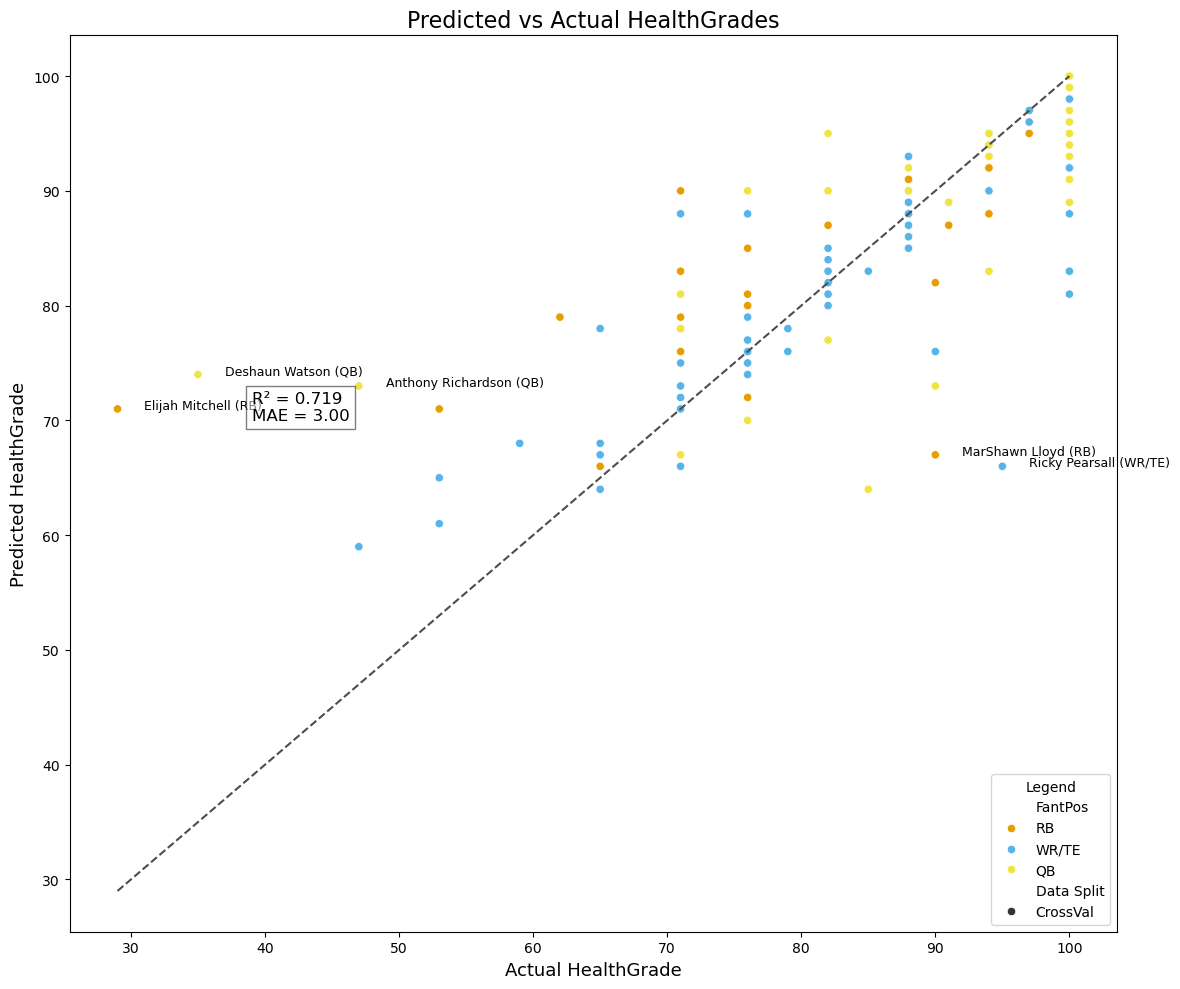

In [172]:
# Compute R² and MAE for the whole dataset
r2 = r2_score(all_predictions['HealthGrade'], all_predictions['PredictedHealthGrade'])
mae = mean_absolute_error(all_predictions['HealthGrade'], all_predictions['PredictedHealthGrade'])

# Compute residuals to find largest errors
all_predictions['Residual'] = np.abs(all_predictions['HealthGrade'] - all_predictions['PredictedHealthGrade'])
top_outliers = all_predictions.nlargest(5, 'Residual')  # Top 5 biggest errors

# Color palette for accessibility (Color Universal Design and Colorblind safe)

color_palette = {
    'RB': '#E69F00',  # orange
    'WR/TE': '#56B4E9',  # blue
    'QB': '#F0E442'   # yellow
}
# Plot
plt.figure(figsize=(12, 10))
sns.scatterplot(
    data=all_predictions,
    x='HealthGrade', y='PredictedHealthGrade',
    hue='FantPos', style='Data Split',
    palette=color_palette
)

# Diagonal line for the predictions
min_val = all_predictions['HealthGrade'].min()
max_val = all_predictions['HealthGrade'].max()
plt.plot([min_val, max_val], [min_val, max_val], ls="--", c=".3")

# Annotate top residual outliers
for _, row in top_outliers.iterrows():
    plt.text(row['HealthGrade'] + 2, row['PredictedHealthGrade'],
             f"{row['Player']} ({row['FantPos']})", fontsize=9, color='black')
    
# Titles and labels
plt.title('Predicted vs Actual HealthGrades', fontsize=16)
plt.xlabel('Actual HealthGrade', fontsize=13)
plt.ylabel('Predicted HealthGrade', fontsize=13)

# Show R² and MAE on the plot
plt.text(min_val + 10, max_val - 30,
         f"R² = {r2:.3f}\nMAE = {mae:.2f}",
         fontsize=12, bbox=dict(facecolor='white', alpha=0.5))

plt.legend(title='Legend', loc='lower right')
plt.tight_layout()
plt.show()

In [36]:
def evaluate_with_cv(position, features, cv=5):
    """Cross-validated evaluation of model for a given position"""
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    if position_data.empty:
        print(f"No data found for position: {position}")
        return None

    X = position_data[features].fillna(0).reset_index(drop=True)
    y = position_data['HealthGrade'].fillna(0).reset_index(drop=True)

    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    mae_scores = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mean_mae = -mae_scores.mean()

    print(f"{position} - Cross-Validated MAE: {mean_mae:.2f}")
    return mean_mae

def retrain_and_predict_full(position, features):
    """Train final model on full data and generate predictions"""
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    X = position_data[features].fillna(0).reset_index(drop=True)
    y = position_data['HealthGrade'].fillna(0).reset_index(drop=True)

    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    rf.fit(X, y)

    y_pred = rf.predict(X)
    position_data = position_data.reset_index(drop=True)
    position_data['Data Split'] = 'FullModel'
    position_data['PredictedHealthGrade'] = y_pred

    # Feature importances
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    return position_data[['Player', 'FantPos', 'Data Split', 'PredictedHealthGrade', 'HealthGrade']]

# Feature sets
features = ['2023Age', '2023G', '2023HealthStatus', '2024Age', '2024G', '2024HealthStatus', 'AvgSeasonGames', '2025Age']

# Evaluate with CV
evaluate_with_cv('RB', features)
evaluate_with_cv('WR/TE', features)
evaluate_with_cv('QB', features)

# Train final model and predict
rb_final = retrain_and_predict_full('RB', features)
wrte_final = retrain_and_predict_full('WR/TE', features)
qb_final = retrain_and_predict_full('QB', features)

# Combine all
all_final_predictions = pd.concat([rb_final, wrte_final, qb_final], ignore_index=True).round(0)

# Save
output_path = "Data/FootballProjectedHealthGrades_Final.csv"
all_final_predictions[['Player', 'Data Split', 'FantPos', 'PredictedHealthGrade', 'HealthGrade']].to_csv(output_path, index=False)

RB - Cross-Validated MAE: 3.39
WR/TE - Cross-Validated MAE: 1.89
QB - Cross-Validated MAE: 6.85

RB - Feature Importances:
            Feature  Importance
5  2024HealthStatus    0.429509
6    AvgSeasonGames    0.312277
2  2023HealthStatus    0.140709
4             2024G    0.046166
1             2023G    0.040233
0           2023Age    0.011615
3           2024Age    0.009910
7           2025Age    0.009580

WR/TE - Feature Importances:
            Feature  Importance
6    AvgSeasonGames    0.382218
5  2024HealthStatus    0.380588
2  2023HealthStatus    0.100433
4             2024G    0.067953
1             2023G    0.038743
7           2025Age    0.012170
0           2023Age    0.011470
3           2024Age    0.006425

QB - Feature Importances:
            Feature  Importance
2  2023HealthStatus    0.498045
5  2024HealthStatus    0.204400
6    AvgSeasonGames    0.118133
1             2023G    0.053777
0           2023Age    0.041709
7           2025Age    0.032675
3           2024Age 

### Not much difference between the Cross Validation and the Retraining of the model after CV. So this model will be able to take in new player information into the pipeline.

## Evaluate data using Random Forest Regressor and Cross Validation- 2025G

In [31]:

# Step 1: Cross-validation function
def train_and_predict_cv(position, features, cv=5):
    # Filter data
    position_data = combined_stats[combined_stats['FantPos'] == position].copy()
    
    if position_data.empty:
        print(f"No data found for position: {position}")
        return pd.DataFrame()

    # Prepare X and y
    X = position_data[features].fillna(0).reset_index(drop=True)
    y = position_data['2025G'].fillna(0).reset_index(drop=True)
    position_data = position_data.reset_index(drop=True)

    # Define model and CV splitter
    rf = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Get cross-validated predictions
    y_pred = cross_val_predict(rf, X, y, cv=kf)

    # Get cross-validation scores
    mae_scores = cross_val_score(rf, X, y, cv=kf, scoring='neg_mean_absolute_error')
    mean_mae = -mae_scores.mean()

    print(f"\n{position} - Cross-Validated MAE: {mean_mae:.2f}")

    # Refit on full data for feature importances
    rf.fit(X, y)
    importance_df = pd.DataFrame({
        'Feature': features,
        'Importance': rf.feature_importances_
    }).sort_values(by='Importance', ascending=False)

    print(f"\n{position} - Feature Importances:")
    print(importance_df)

    # Store predictions
    position_data['Data Split'] = 'CrossVal'
    position_data['Predicted2025G'] = y_pred
    return position_data[['Player', 'FantPos', 'Data Split', 'Predicted2025G', '2025G']]

# Step 2: Feature sets
rb_features = ['2023Age', '2023G', '2023HealthStatus', '2024Age', '2024G', '2024HealthStatus', 'AvgSeasonGames', '2025Age']
wrte_features = rb_features
qb_features = rb_features

# Step 3: Apply to all positions
rb_predictions = train_and_predict_cv('RB', rb_features)
wrte_predictions = train_and_predict_cv('WR/TE', wrte_features)
qb_predictions = train_and_predict_cv('QB', qb_features)

# Step 4: Combine and round
all_predictions = pd.concat([rb_predictions, wrte_predictions, qb_predictions]).round(0)

# Step 4: Save results
output_path = "Data/FootballProjected2025G_CV.csv"
all_predictions.to_csv(output_path, index=False)


RB - Cross-Validated MAE: 1.17

RB - Feature Importances:
            Feature  Importance
4             2024G    0.212443
6    AvgSeasonGames    0.211267
0           2023Age    0.138164
1             2023G    0.132354
5  2024HealthStatus    0.124034
7           2025Age    0.068078
3           2024Age    0.061268
2  2023HealthStatus    0.052391

WR/TE - Cross-Validated MAE: 0.73

WR/TE - Feature Importances:
            Feature  Importance
4             2024G    0.254915
1             2023G    0.199603
5  2024HealthStatus    0.116553
7           2025Age    0.106983
6    AvgSeasonGames    0.095561
3           2024Age    0.086028
0           2023Age    0.080717
2  2023HealthStatus    0.059640

QB - Cross-Validated MAE: 1.34

QB - Feature Importances:
            Feature  Importance
2  2023HealthStatus    0.168777
4             2024G    0.158389
6    AvgSeasonGames    0.157233
1             2023G    0.149952
5  2024HealthStatus    0.113646
0           2023Age    0.085878
7           2025A

In [33]:
# Evaluate R² and MAE by position
position_metrics = []

for pos in all_predictions['FantPos'].unique():
    subset = all_predictions[all_predictions['FantPos'] == pos]
    r2 = r2_score(subset['2025G'], subset['Predicted2025G'])
    mae = mean_absolute_error(subset['2025G'], subset['Predicted2025G'])
    position_metrics.append({'Position': pos, 'R²': round(r2, 3), 'MAE': round(mae, 2)})

# Convert to DataFrame for easy viewing
position_metrics_df = pd.DataFrame(position_metrics)

print("\nHealth Metrics by Position:")
print(position_metrics_df)


Health Metrics by Position:
  Position     R²   MAE
0       RB -0.218  1.09
1    WR/TE -0.596  0.69
2       QB -0.132  1.32


## Evaluate data using Random Forest Classification and Cross Validation

In [39]:

# Step 1: Create binary target variable — will play >14 games in 2025
combined_stats['PlayMoreThan14'] = (combined_stats['AvgSeasonGames'] > 14).astype(int)

# Step 2: Compute Injury Risk Score (0–5)
combined_stats['InjuryRiskScore'] = combined_stats['2023HealthStatus'] + combined_stats['2024HealthStatus']

# Step 3: Adjust risk score by adding modifiers
combined_stats['AdjustedRisk'] = (
     combined_stats['InjuryRiskScore'] +
    (combined_stats['2025Age'] > 30).astype(int) +
    (combined_stats['HealthGrade'] < 80).astype(int)
)

# Step 4: Assign Risk Tier
def assign_risk_tier(score):
    if score <= 1:
        return 'Low'
    elif score <= 2:
        return 'Minor'
    elif score <= 3:
        return 'Moderate'
    elif score <= 5:
        return 'High'
    else:
        return 'Significant'

combined_stats['RiskTier'] = combined_stats['AdjustedRisk'].apply(assign_risk_tier)

# Step 5: Train classifier per position
def train_classification_model(position, features, cv=5):
    data = combined_stats[combined_stats['FantPos'] == position].copy()
    if data.empty:
        print(f"No data for position: {position}")
        return pd.DataFrame()

    X = data[features].fillna(0)
    y = data['PlayMoreThan14']

    clf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
    kf = KFold(n_splits=cv, shuffle=True, random_state=42)

    # Cross-validated predictions
    predictions = cross_val_predict(clf, X, y, cv=kf)

    # Accuracy metrics
    acc = accuracy_score(y, predictions)
    print(f"\n{position} - Accuracy: {acc:.3f}")
    print(classification_report(y, predictions))

    # Fit on full data and return predictions
    clf.fit(X, y)
    data['PredictedPlayMoreThan14'] = predictions

    return data[['Player', 'FantPos', 'PlayMoreThan14', 'PredictedPlayMoreThan14', 'AdjustedRisk', 'RiskTier']]

# Step 6: Define shared features
base_features = ['2023Age', '2023G', '2023HealthStatus', '2024Age', '2024G', '2024HealthStatus', '2025Age']

# Step 7: Run for each position
rb_results = train_classification_model('RB', base_features)
wrte_results = train_classification_model('WR/TE', base_features)
# te_results = train_classification_model('TE', base_features)
qb_results = train_classification_model('QB', base_features)

# Step 8: Combine and export
all_classification_results = pd.concat([rb_results, wrte_results, qb_results])
all_classification_results.to_csv("Data/Football_Injury_Classification_Results.csv", index=False)


RB - Accuracy: 0.830
              precision    recall  f1-score   support

           0       0.85      0.83      0.84        47
           1       0.81      0.83      0.82        41

    accuracy                           0.83        88
   macro avg       0.83      0.83      0.83        88
weighted avg       0.83      0.83      0.83        88


WR/TE - Accuracy: 0.884
              precision    recall  f1-score   support

           0       0.88      0.82      0.84        60
           1       0.89      0.93      0.91        95

    accuracy                           0.88       155
   macro avg       0.88      0.87      0.88       155
weighted avg       0.88      0.88      0.88       155


QB - Accuracy: 0.842
              precision    recall  f1-score   support

           0       0.87      0.87      0.87        23
           1       0.80      0.80      0.80        15

    accuracy                           0.84        38
   macro avg       0.83      0.83      0.83        38
weigh